In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL
from PIL import Image
import time
import random

In [3]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps*4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.network(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 64
num_classes = 1
learning_rate = 0.002
num_epochs = 100
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2

In [5]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True,
)

#indices = (train_dataset.targets == 1) |\
#          (train_dataset.targets == 2) |\
#          (train_dataset.targets == 4) |\
#          (train_dataset.targets == 5) |\
#          (train_dataset.targets == 6) |\
#          (train_dataset.targets == 7) |\
#          (train_dataset.targets == 8) |\
#          (train_dataset.targets == 9)

indices = (train_dataset.targets == 9)
train_dataset.data, train_dataset.targets = train_dataset.data[indices], train_dataset.targets[indices]



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Save/Load models into generator and discriminator models

In [7]:
%cd /content/drive/My Drive/Colab/
!ls

def save_checkpoint(epoch):
    timestamp = time.time()
    torch.save(generator.state_dict(),f'./saved_models/generator_epoch_{epoch}_{timestamp}.pkl')
    torch.save(discriminator.state_dict(),f'./saved_models/discriminator_epoch_{epoch}_{timestamp}.pkl')

def save_models():
    torch.save(generator.state_dict(),f'./saved_models/generator.pkl')
    torch.save(discriminator.state_dict(),f'./saved_models/discriminator.pkl')

def load_models():
    generator.load_state_dict(torch.load("./saved_models/generator.pkl", map_location=torch.device(device)))
    discriminator.load_state_dict(torch.load('./saved_models/discriminator.pkl', map_location=torch.device(device)))

/content/drive/My Drive/Colab
AdGAN  data  saved_models


Train the GAN

In [8]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, size_z, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

def train_gan():
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            # get batch-size from actual image batch
            bs = real_images.shape[0]

            # -- train discriminator --

            # reset/clear discriminators gradient
            discriminator.zero_grad()

            # move images to either CPU or GPU
            real_images = real_images.to(device)

            # creates a label tensor filled with 1s
            label = torch.full((bs,), real_label, dtype=torch.float, device=device)

            # get probs for discriminators guess on the real images
            output, _ = discriminator(real_images)

            # get loss for real images. that means it calculates the difference
            # between the output of the model with the current parameter and the
            # target (goal) of what the model is supposed to do
            # output --> current outcome of the model
            # label  --> target of the model
            lossD_real = criterion(output, label)

            # calculates the gradient (using chain-rule)
            # see https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
            lossD_real.backward()

            # Gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations (for real data ) --> D(x)
            D_x = output.mean().item()

            # create noise as an input for the G in order to create fake images
            noise = torch.randn(bs, size_z, 1, 1, device=device)

            # use generator to map input noise to an output that is supposed do become fake images during training
            fake_images = generator(noise)

            # creates a label tensor filled with 0s
            label.fill_(fake_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images.detach())

            # get loss for fake images
            lossD_fake = criterion(output, label)

            # adjust parameter to identify fakes
            lossD_fake.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z1 = output.mean().item()

            # calculate loss
            lossD = lossD_real + lossD_fake

            # adjust models (discriminator) parameter
            optimizerD.step()

            # -- train generator --

            # reset/clear generators gradient
            generator.zero_grad()

            # creates a label tensor filled with 1s
            label.fill_(real_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images)
            output = output.view(-1)

            # get loss for fake images
            lossG = criterion(output, label)

            # adjust parameter to generate fakes
            lossG.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z2 = output.mean().item()

            # adjust models (generator) parameter
            optimizerG.step()
            # Save Losses for plotting later
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch+1, num_epochs, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
        
        if epoch%5 == 0:
          save_checkpoint(epoch)

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.rcParams['animation.embed_limit'] = 100
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

Inference

In [9]:
def get_anomaly_score(x_query, g_z):
    _, x_prop = discriminator(x_query)
    _, g_z_prop = discriminator(g_z)

    loss_residual = torch.sum(torch.abs(x_query - g_z))
    loss_discriminative = torch.sum(torch.abs(x_prop - g_z_prop))

    return (1-.1)*loss_residual + .1* loss_discriminative

In [20]:
start_idx = 0
test_size = 3

test_images = test_dataset.__dict__['data'][start_idx:start_idx + test_size]
test_images = test_images.view(test_size, 1, 28, 28).type_as(torch.FloatTensor())
test_images.shape



torch.Size([3, 1, 28, 28])

In [11]:
z = torch.randn(8, size_z, 1, 1, device=device, requires_grad=True)

In [12]:
def generate_anomaly():
    random_idx = random.randint(0, len(train_dataset.data)-1)
    img, _ = train_dataset[random_idx]
    img = img.numpy()

    random_idx = random.randint(4, 20)
    img[0][random_idx:random_idx+3] = np.ones(28, dtype="float32")-2
    return np.expand_dims(img, axis=0)


tests = generate_anomaly()
for i in range(test_size-1):
    tests = np.concatenate((tests, generate_anomaly()))
tests = torch.from_numpy(tests)

tests.shape

torch.Size([8, 1, 28, 28])

In [25]:
def run_inference():
    z_optimizer = torch.optim.Adam([z],lr=1e-4)
    losses = []
    for i in range(50000):
        gen_fake = generator(z.to(device))
        loss = get_anomaly_score(Variable(tests).to(device), gen_fake)
        loss.backward()
        z_optimizer.step()
        if i%1000==0:
            print("Anomaly Score: %s" %(loss.data.item()))
            losses.append(loss.data.item())

    plt.figure(figsize=(10, 5))
    plt.title("Anomaly Score trajectory during optimization")
    plt.plot(losses, label="Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def test_inferences():
    gen_fake = generator(z.to(device))
    for idx in range(test_size):
        target = tests[idx, 0, :, :].numpy()
        img = gen_fake.cpu().data[idx,0,:,:].numpy()

        NUM_ROWS = 1
        IMGs_IN_ROW = 3
        f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(8,4))

        f.add_subplot(NUM_ROWS, IMGs_IN_ROW, 1)
        plt.imshow(target, cmap="binary")
        plt.axis('off')
        plt.title("Query Image")

        f.add_subplot(NUM_ROWS, IMGs_IN_ROW, 2)
        plt.imshow(img, cmap="binary")
        plt.axis('off')
        plt.title("G(z_Gamma)")

        # img += 1.5

        diff = np.isclose(img, target, rtol=0.8, atol=0.004)
        # display(diff.astype("uint8"))

        img_pil = Image.fromarray(img.astype(np.uint8))
        target_pil = Image.fromarray(target.astype(np.uint8))
        # subtracted = PIL.ImageChops.subtract(img_pil, target_pil)
        subtracted = Image.fromarray(diff)

        f.add_subplot(NUM_ROWS, IMGs_IN_ROW, 3)
        plt.imshow(subtracted, cmap="binary")
        plt.axis('off')
        plt.title("|G(z_Gamma) - x|")

        plt.tight_layout()
        plt.show()

In [ ]:
train_gan()

In [15]:
save_models()

In [ ]:
load_models()
run_inference()

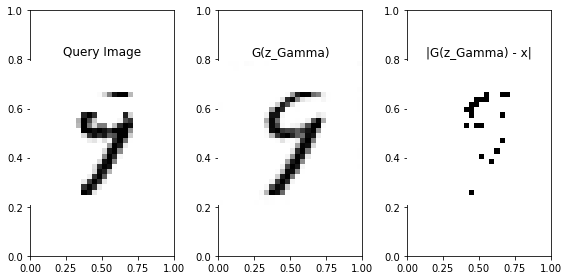

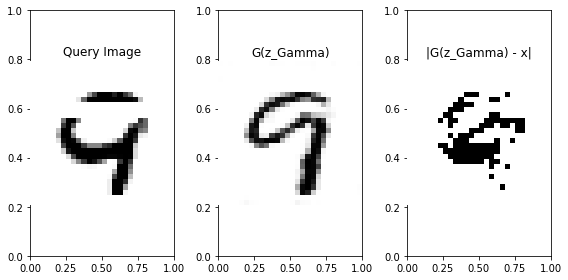

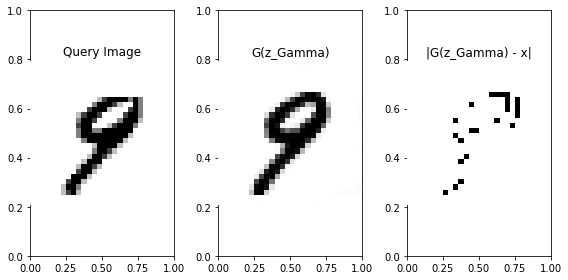

In [26]:
test_inferences()